<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Auswertung_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import keras
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
testdata_path_X = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_X.csv'
testdata_path_Y = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_Y.csv'

txt_file_path = "/content/drive/MyDrive/Colab_Notebooks/LSTM_Model/model_results.txt"

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'

In [4]:
def parse_model_log(txt_path):
    """
    Liest die Logdatei ein und erstellt eine Tabelle (pd.DataFrame),
    bei der jeder Block einen Eintrag repräsentiert.
    """
    data = []           # Hier sammeln wir alle Einträge (als dict)
    current_entry = {}  # Temporäres Dictionary für den aktuellen Block
    in_entry = False    # Flag, ob wir uns aktuell in einem "=== Model Results ==="-Block befinden

    if not os.path.exists(txt_path):
        raise FileNotFoundError(f"Die angegebene Datei {txt_path} existiert nicht.")

    with open(txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Blockanfang
            if line.startswith("=== Model Results ==="):
                current_entry = {}
                in_entry = True
                continue

            # Blockende
            if line.startswith("======================"):
                if in_entry and current_entry:
                    data.append(current_entry)
                in_entry = False
                current_entry = {}
                continue

            # Innerhalb des Blocks: Zeilen "key: value" verarbeiten
            if in_entry and line:
                # Erwartete Struktur: "key: value"
                if ": " in line:
                    key, value = line.split(": ", 1)
                    current_entry[key] = value
                # Falls Zeilen ohne ": " vorkommen, kannst du sie ggf. überspringen
                # else:
                #    pass

    # Jetzt haben wir eine Liste aus Dictionaries, jeder entspricht einem Log-Block
    df = pd.DataFrame(data)
    return df

In [5]:
# Beispiel: Lies aus dem Drive
df_results = parse_model_log(txt_file_path)

In [6]:
df_results

,model_name,model_config.units_1,model_config.units_2,model_config.dropout_rate,model_config.final_activation,training_config.loss,training_config.optimizer,training_config.metrics,fit_config.epochs,fit_config.batch_size,...,val_loss,val_mse,val_mae,val_rmse,test_loss,test_mse,test_mae,test_rmse,val_r2,test_r2
0,Baseline LSTM,64,32,0.1,linear,mean_squared_error,adam,"['mse', 'mae', 'mape', <RootMeanSquaredError n...",5,32,...,0.007743313908576965,0.007743313908576965,0.05897708237171173,44.57095718383789,0.00892695877701044,0.00892695877701044,0.06294387578964233,60.592220306396484,0.7900590413070319,0.7836071803082321
1,Baseline_LSTM_alles_außer_ghi,64,32,0.1,linear,mean_squared_error,adam,"['mse', 'mae', 'mape', <RootMeanSquaredError n...",10,32,...,0.003919987473636866,0.003919987473636866,0.03684864938259125,41.497379302978516,0.004294680431485176,0.004294680431485176,0.041024819016456604,93.15336608886719,0.8937192160058077,0.8958953560946943
2,Baseline_LSTM_alles_außer_ghi,64,32,0.1,linear,mean_squared_error,adam,"['mse', 'mae', 'mape', <RootMeanSquaredError n...",20,32,...,0.005893732886761427,0.005893732886761427,0.045790765434503555,34.923187255859375,0.004697789903730154,0.004697789903730154,0.044077515602111816,49.67070007324219,0.8402058319643553,0.8861238401305697


## Import des letzen berechneten Modells und Testdaten:

In [7]:
df_test_X = pd.read_csv(testdata_path_X)  # Beispiel für das Einlesen eines CSV
df_test_Y = pd.read_csv(testdata_path_Y)

# Wandeln des DataFrames in ein NumPy-Array
array_X = df_test_X.to_numpy()
array_Y = df_test_Y.to_numpy()

# Reshaping des Arrays auf die gewünschte Form (9656, 16, 10)
X_test_seq = array_X.reshape((9608, 64, 10))
y_test_seq = array_Y.reshape(9608, 1).flatten()

## Import der Modellarchitektur

In [8]:
model = load_model(model_path)

## Berechnen des Modelloutputs

In [9]:
y_pred = model.predict(X_test_seq).flatten()

301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


## Plotten der Modellleistung:

In [10]:
def compare_model_output(model, X_test, y_test, plot_indices=None):

    # Vorhersage berechnen
    y_pred = model.predict(X_test)
    # Arrays abflachen für leichtere Handhabung
    y_pred = y_pred.flatten()
    y_test = y_test.flatten()

    # Metriken berechnen
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Ergebnis ausgeben
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Gesamten Vergleich plotten
    plt.figure(figsize=(12, 4))
    plt.plot(y_pred, label='Vorhersage', alpha=0.7)
    plt.plot(y_test, label='Tatsächlicher Wert', alpha=0.7)
    plt.title('Vergleich Vorhersage vs. Tatsächlicher Wert')
    plt.legend()
    plt.show()

    # Optionaler Detailplot für einen Index-Bereich
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 4))
        plt.plot(np.arange(start, end), y_pred[start:end], label='UVI Vorhersage', alpha=0.7)
        plt.plot(np.arange(start, end), y_test[start:end], label='UVI Messung', alpha=0.7)
        plt.title(f'Detailplot (Index {start} - {end})')
        plt.legend()
        plt.show()

301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Mean Squared Error (MSE): 0.0054
Mean Absolute Error (MAE): 0.0468


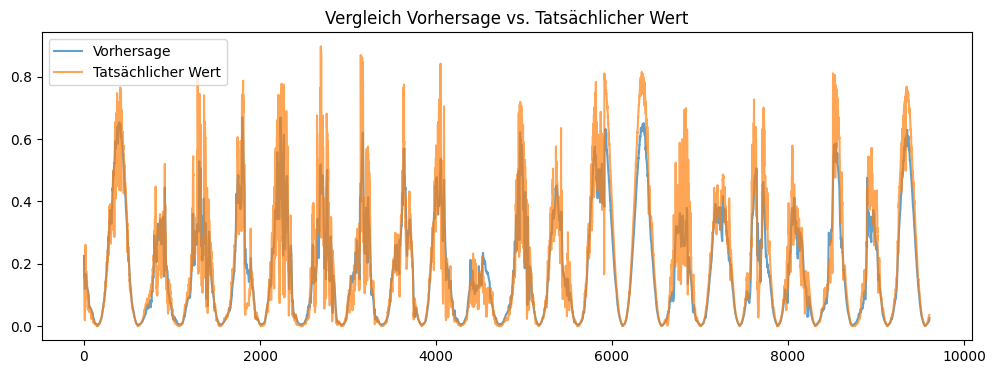

In [11]:
compare_model_output(model, X_test_seq, y_test_seq, plot_indices=None)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Mean Squared Error (MSE): 0.0020
Mean Absolute Error (MAE): 0.0253


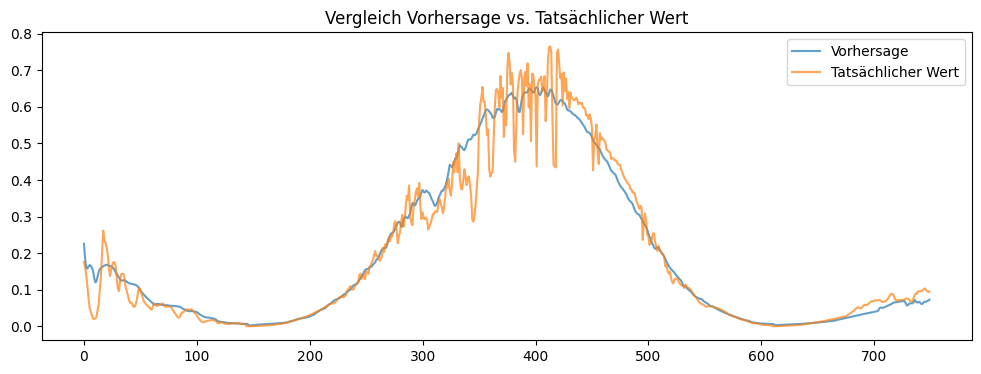

In [12]:
compare_model_output(model, X_test_seq[:750], y_test_seq[:750], plot_indices=None)

In [13]:
def plot_largest_deviation(y_pred, y_true, window=250):

    # Sicherstellen, dass beide Arrays gleich lang sind
    if len(y_pred) != len(y_true):
        raise ValueError(f"Inkonsistente Längen: y_pred={len(y_pred)}, y_true={len(y_true)}")

    # Index der größten Abweichung bestimmen
    diff = np.abs(y_pred - y_true)
    max_idx = np.argmax(diff)

    # Anzeigebereich für den Plot definieren (Begrenzung beachten)
    start_idx = max(0, max_idx - window)
    end_idx = min(len(y_pred), max_idx + window)

    # Plot erstellen
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(start_idx, end_idx), y_true[start_idx:end_idx],
             label='Messwerte (y_val)', alpha=0.7)
    plt.plot(np.arange(start_idx, end_idx), y_pred[start_idx:end_idx],
             label='Vorhersage (y_pred)', alpha=0.7)
    # Hervorhebung des Punktes mit größter Abweichung
    plt.scatter(max_idx, y_true[max_idx], color='red', s=80, marker='x', label='Größte Abweichung')

    plt.title(f'Größte Abweichung bei Index={max_idx} (Abweichung={diff[max_idx]:.4f})')
    plt.xlabel('Index')
    plt.ylabel('Wert')
    plt.legend()
    plt.show()

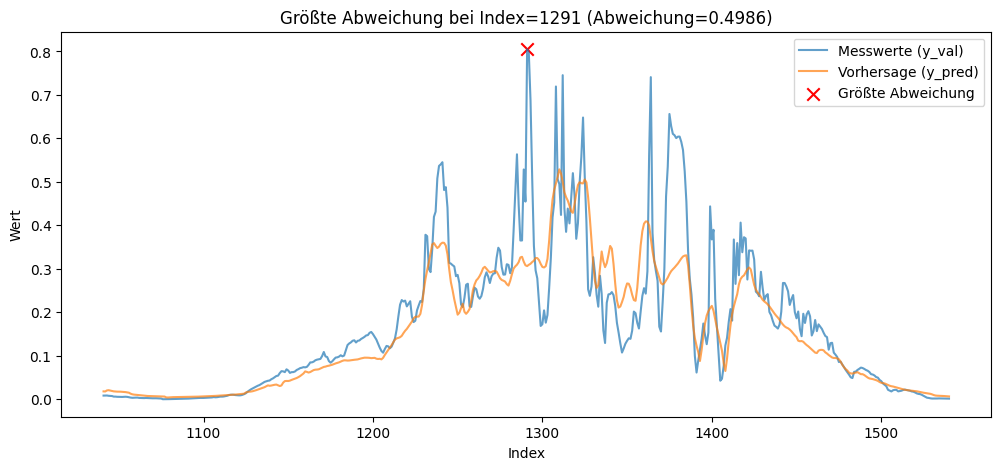

In [14]:
plot_largest_deviation(y_pred, y_test_seq)

In [15]:
def plot_input_output(X_test_seq, y_pred, y_test_seq, num_samples=20):
    """
    Erstellt für die ersten 'num_samples' Zeitsequenzen Plots:
    - Links: Liniendiagramm für die 10 Features über 16 Zeitschritte
    - Rechts: Balkendiagramm für die vorhergesagten und tatsächlichen Werte

    Parameters:
    X_test_seq : np.array
        Eingangssequenzen (9656, 16, 10) -> 16 Zeitschritte, 10 Features
    y_pred : np.array
        Vorhergesagte Werte (9656,)
    y_test_seq : np.array
        Tatsächliche Werte (9656,)
    num_samples : int
        Anzahl der zu plottenden Sequenzen (Standard: 100)
    """

    num_samples = min(num_samples, len(X_test_seq))  # Sicherstellen, dass num_samples nicht größer ist als die Datenmenge

    for i in range(num_samples):
        plt.figure(figsize=(10, 4))

        # **LINKS: Liniendiagramm für die 10 Features**
        plt.subplot(1, 2, 1)
        for feature in range(X_test_seq.shape[2]):  # 10 Features iterieren
            plt.plot(range(X_test_seq.shape[1]), X_test_seq[i, :, feature], label=f'Feature {feature+1}', alpha=0.7)
        plt.xlabel('Zeitschritt')
        plt.ylabel('Feature-Wert')
        plt.title(f'Sample {i+1}: Input-Sequenz')
        plt.legend(loc='upper right', fontsize=8)

        # **RECHTS: Balkendiagramm für die Vorhersage vs. Ground Truth**
        plt.subplot(1, 2, 2)
        plt.bar(['Tatsächlich', 'Vorhersage'], [y_test_seq[i], y_pred[i]], color=['blue', 'orange'])
        plt.ylabel('Output-Wert')
        plt.title('Vorhersage vs. Tatsächlicher Wert')

        plt.tight_layout()
        plt.show()  # Falls gewünscht, hier stattdessen speichern: plt.savefig(f'plot_{i}.png')

Feature 1 = Clear_sky_GHI
Feature 2 = Clear_sky_BHI
Feature 3 = GHI
Feature 4 = BHI
Feature 5 = Temp
Feature 6 = SZA
Feature 7 = time_sin
Feature 8 = time_cos
Feature 9 = date_sin
Feature 10 = date_cos

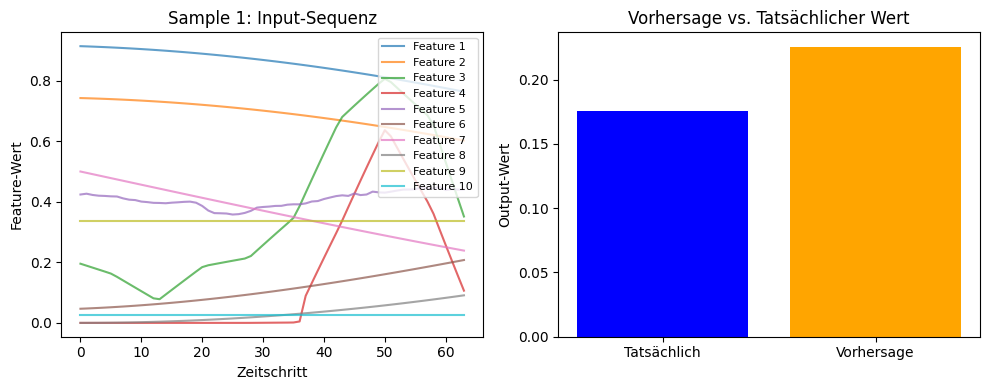

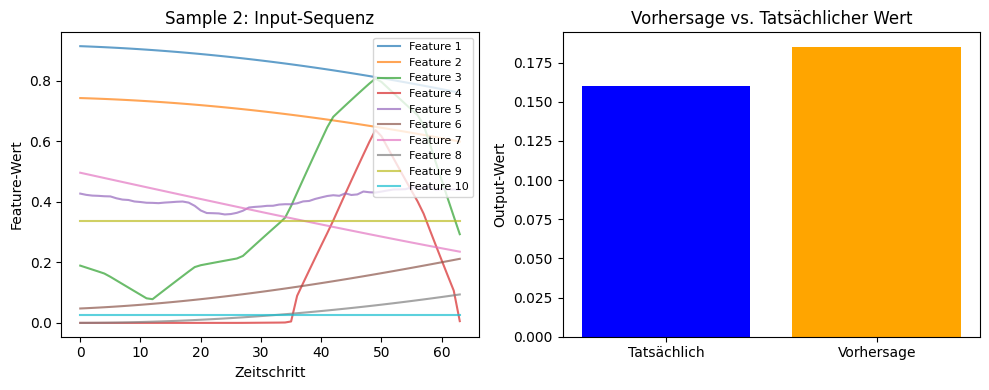

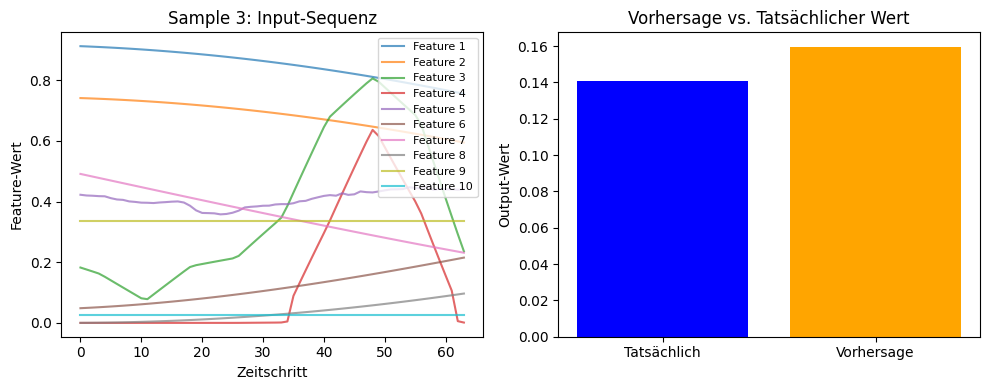

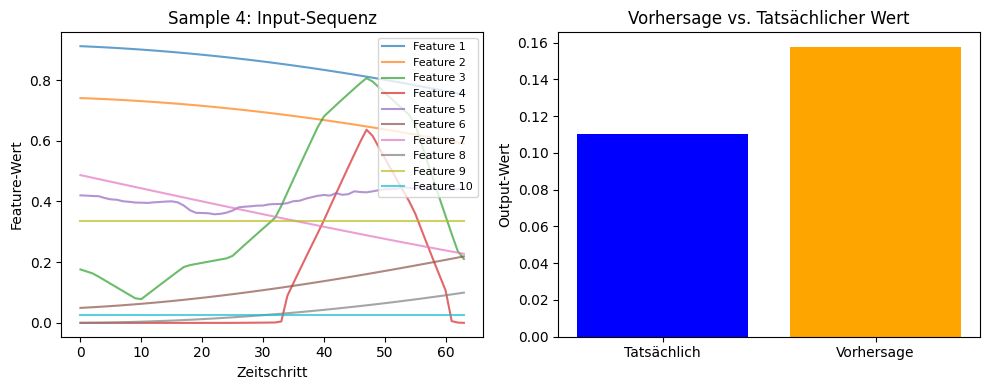

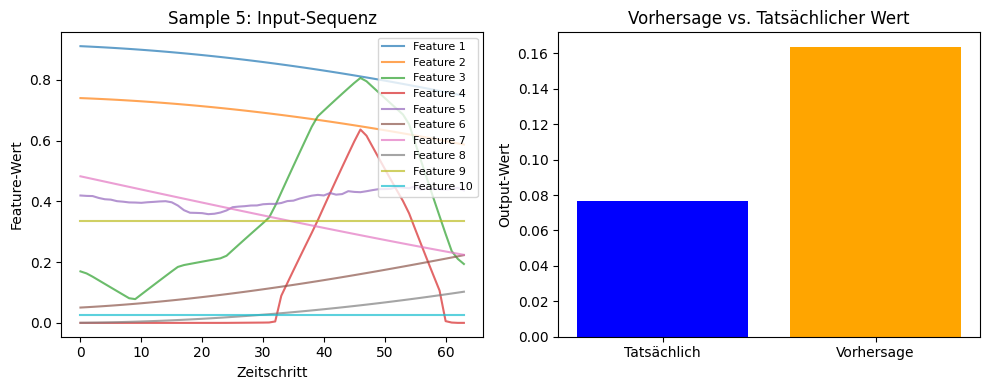

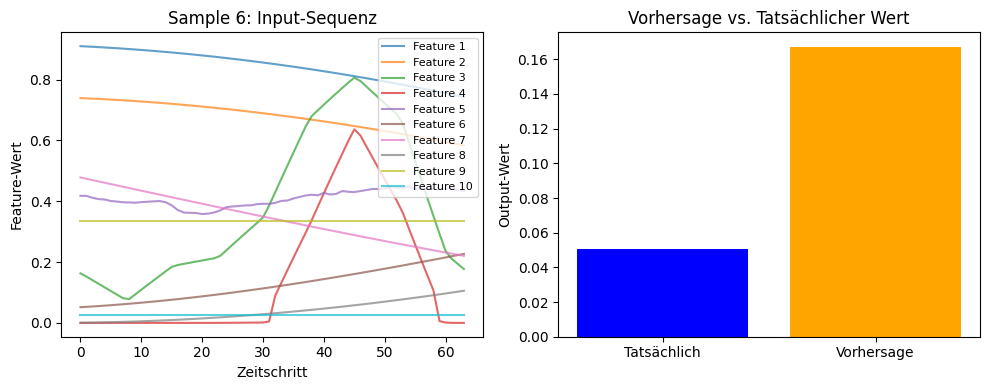

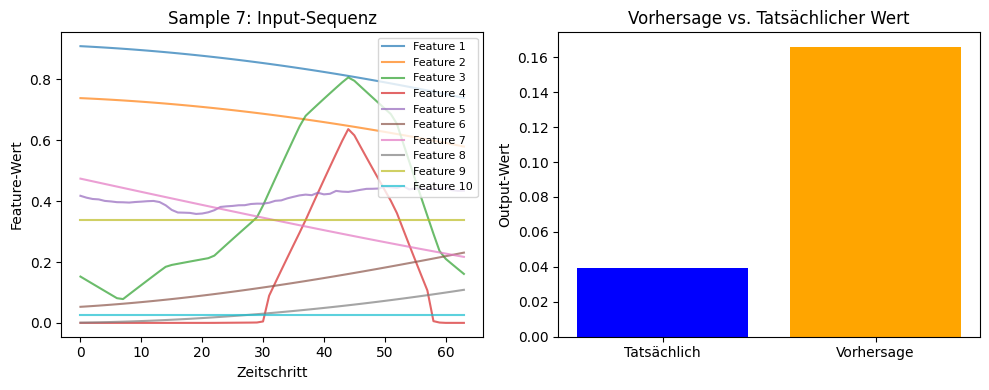

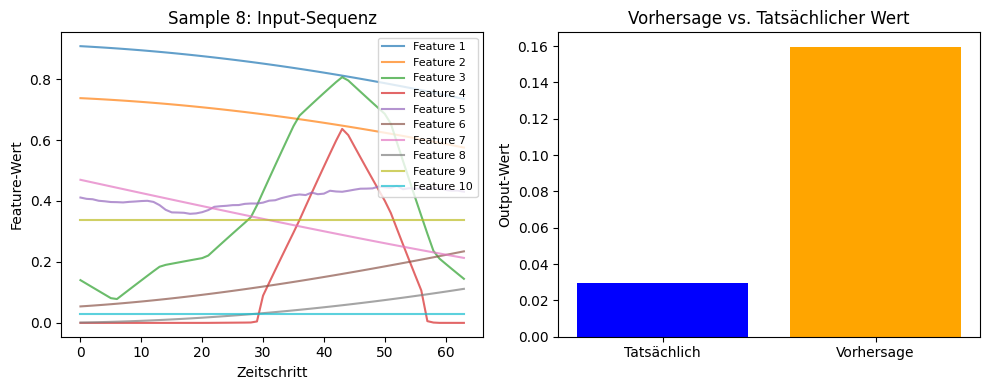

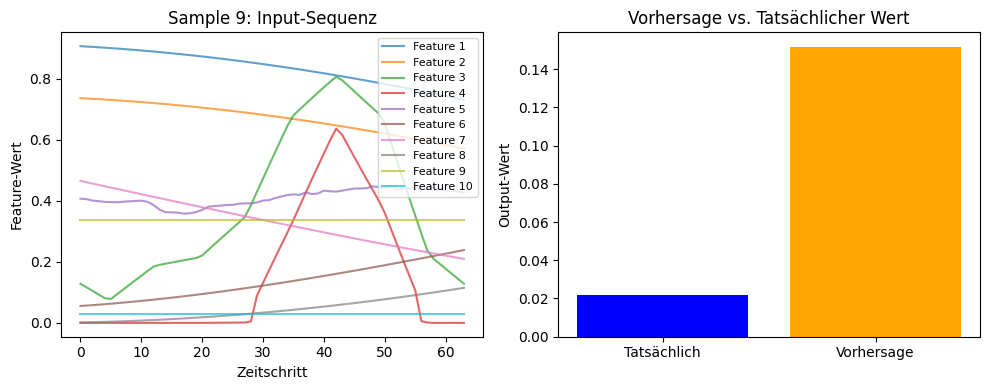

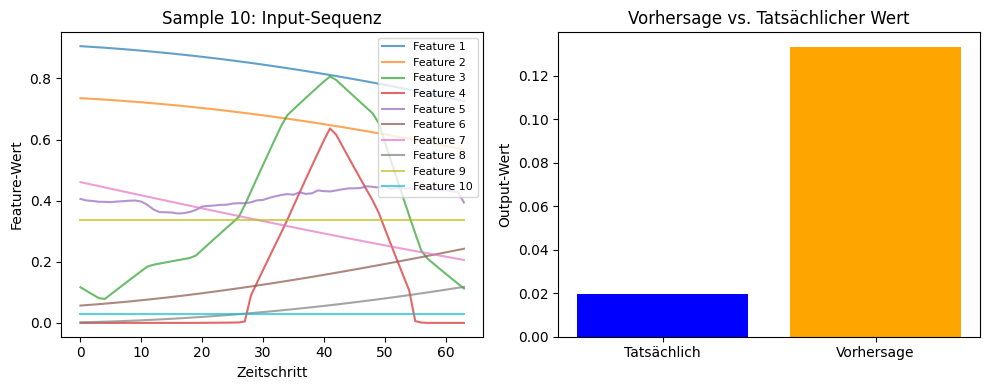

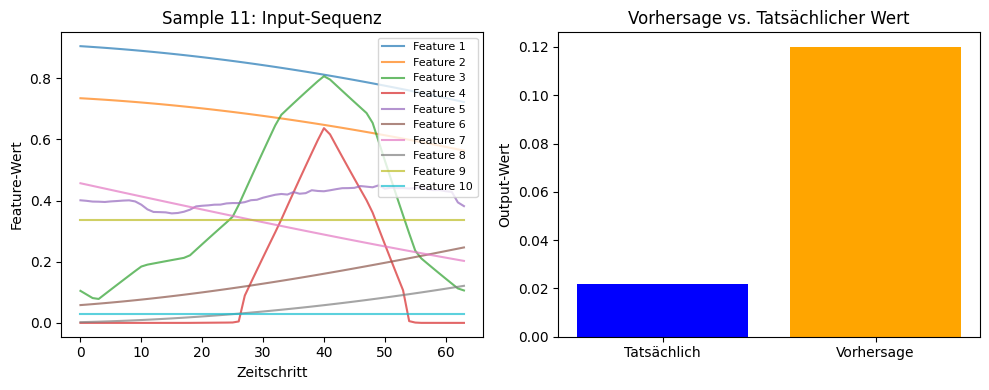

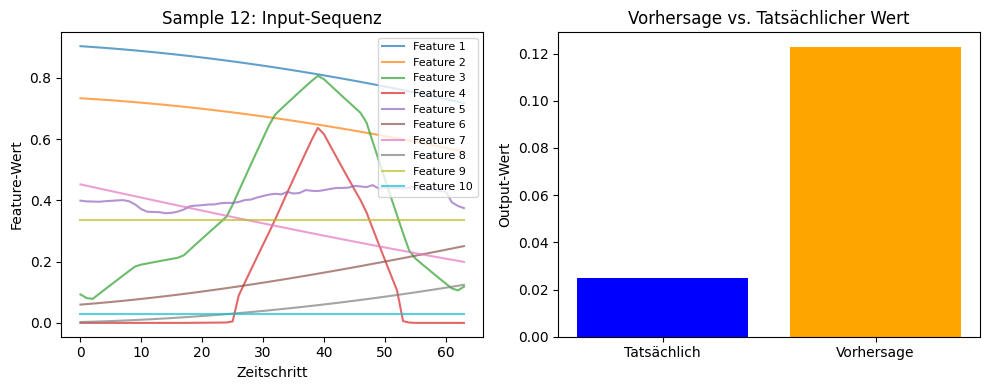

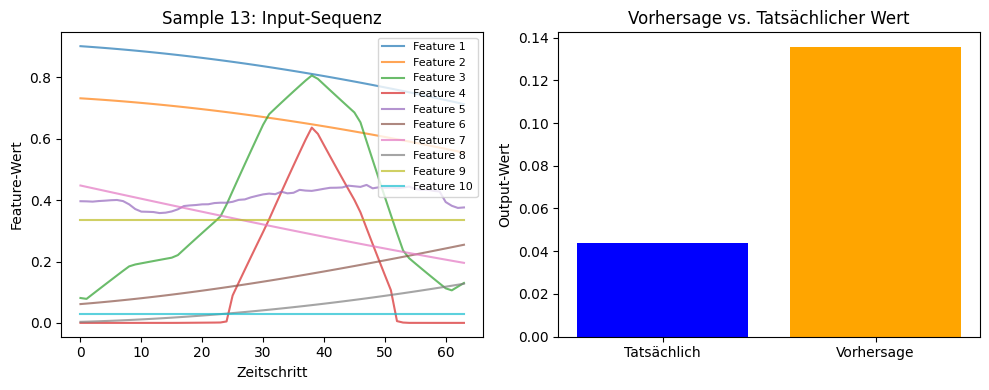

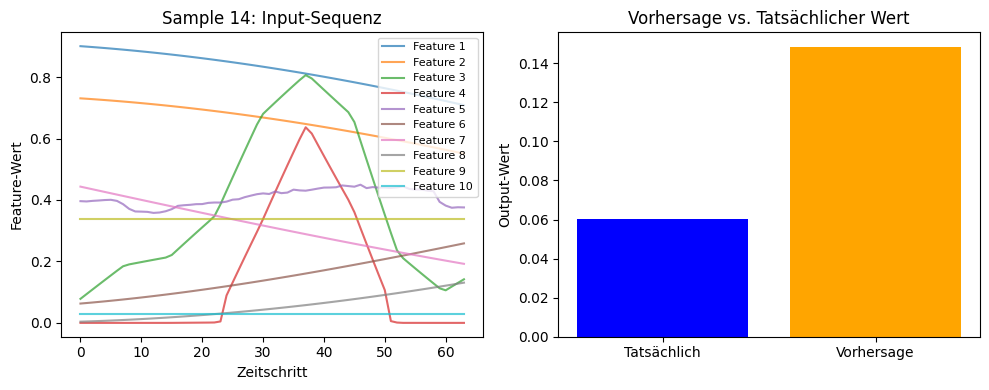

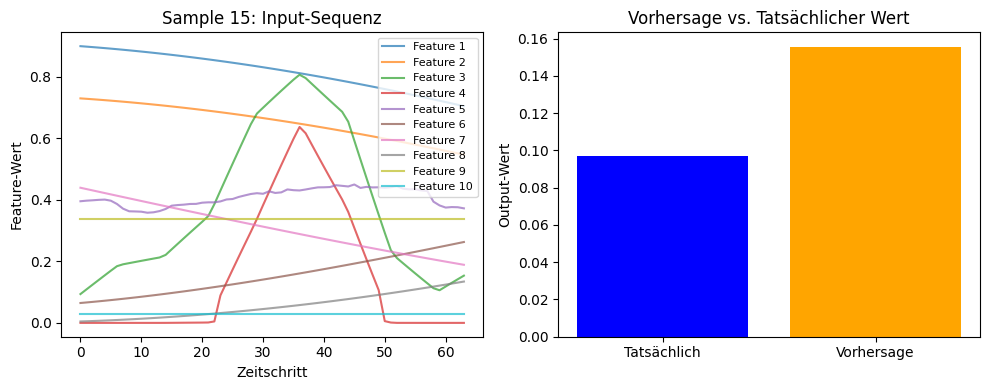

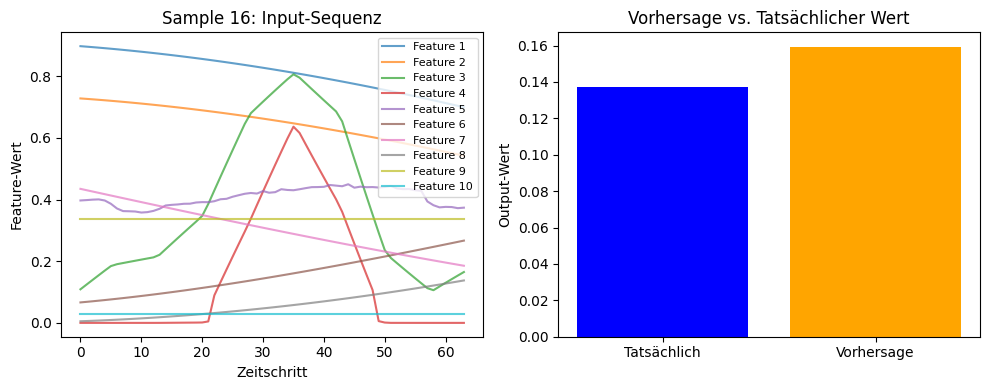

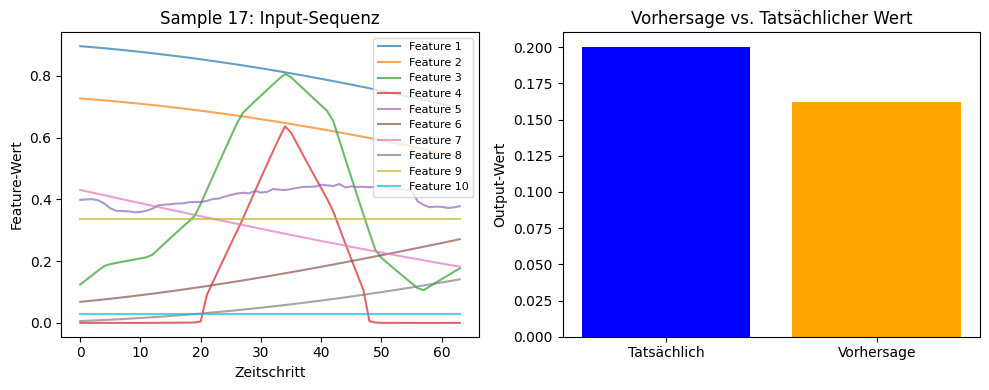

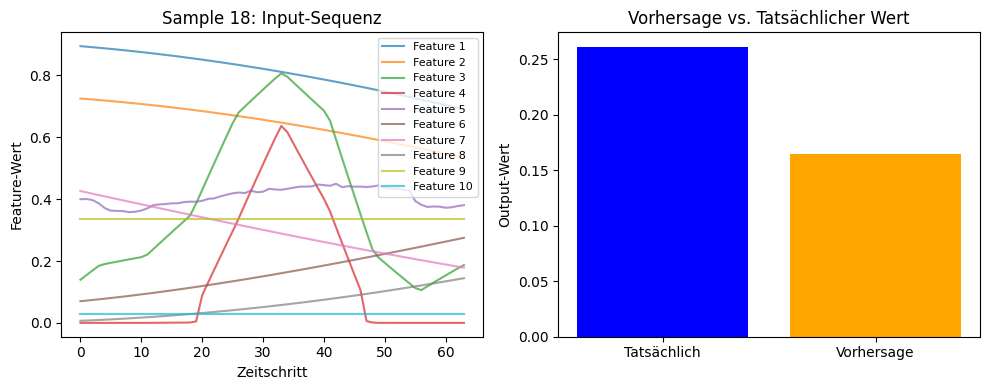

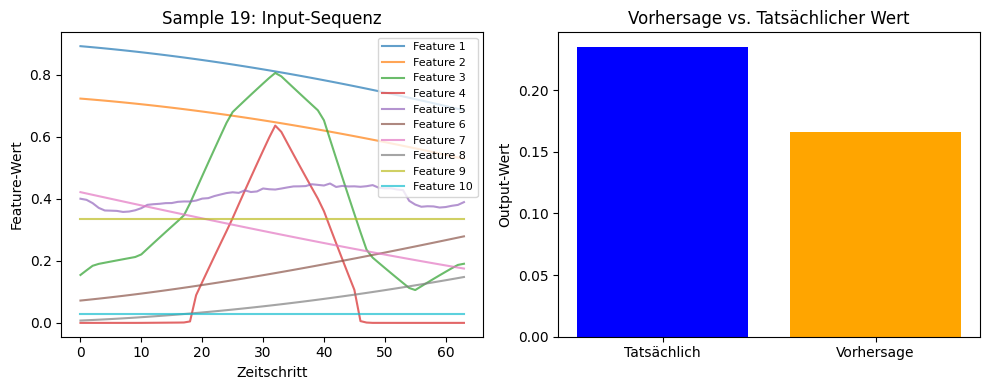

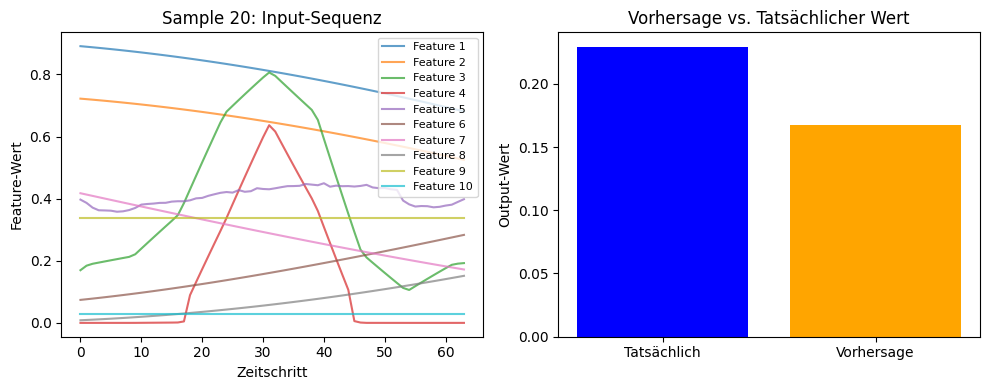

In [16]:
plot_input_output(X_test_seq, y_pred, y_test_seq)

## Plotten der Fehlerverteilung:

In [17]:
def plot_residuals_histogram(y_true, y_pred, bins=50):
    """
    Erstellt ein Histogramm der Residuen (Fehlerverteilung).

    Parameters:
    y_true : np.array
        Tatsächliche Werte
    y_pred : np.array
        Vorhergesagte Werte
    bins : int
        Anzahl der Bins im Histogramm (Standard: 50)
    """

    # Berechnung der Residuen (Fehler)
    residuals = y_true - y_pred

    # Erstellen des Histogramms
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=bins, edgecolor='black', alpha=0.7)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label='Fehler = 0')

    # Achsenbeschriftungen und Titel
    plt.xlabel('Residuen (y_true - y_pred)')
    plt.ylabel('Häufigkeit')
    plt.title('Histogramm der Residuen')
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

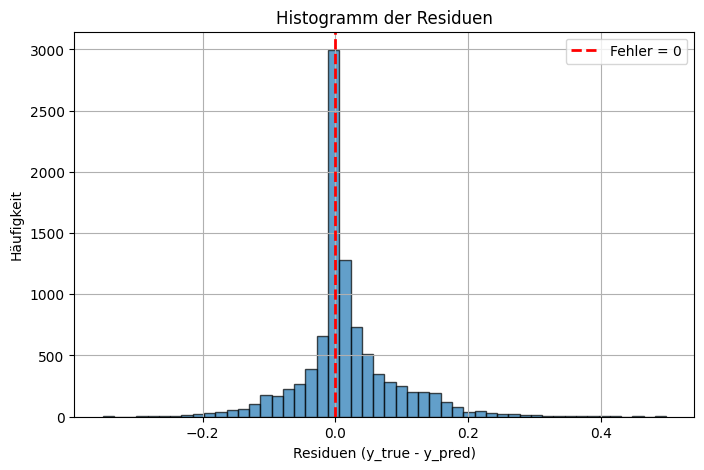

In [18]:
plot_residuals_histogram(y_test_seq, y_pred)

## Fehler über die Zeit:

In [19]:
def plot_rolling_error(y_true, y_pred, window_size=100):
    """
    Plottet den gleitenden Fehler (absolute Residuen) über die Zeit.

    Parameters:
    y_true : np.array
        Tatsächliche Werte
    y_pred : np.array
        Vorhergesagte Werte
    window_size : int
        Größe des gleitenden Fensters (Standard: 100)
    """

    # Fehler berechnen (absolute Residuen)
    error = np.abs(y_true - y_pred)

    # Gleitenden Mittelwert berechnen
    rolling_error = pd.Series(error).rolling(window=window_size, center=True).mean()

    # Plot erstellen
    plt.figure(figsize=(10, 5))
    plt.plot(error, alpha=0.3, label='Fehler (|y_true - y_pred|)', color='gray')
    plt.plot(rolling_error, color='red', label=f'Gleitender Fehler (window={window_size})', linewidth=2)

    # Achsenbeschriftungen & Titel
    plt.xlabel('Zeit (Index)')
    plt.ylabel('Fehler (Absolut)')
    plt.title('Gleitender Fehler über die Zeit')
    plt.legend()
    plt.grid(True)

    # Plot anzeigen
    plt.show()

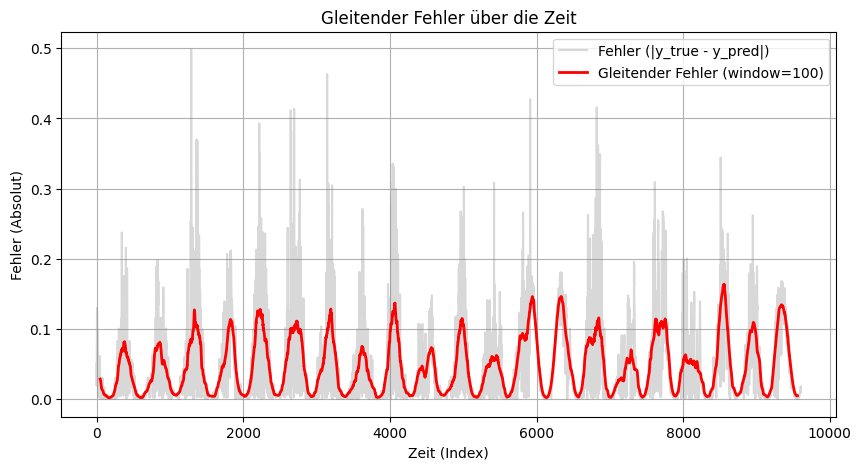

In [20]:
plot_rolling_error(y_test_seq, y_pred)

## Autokorrelation der Fehler:

In [21]:
def plot_acf_errors(y_true, y_pred, lags=50):
    """
    Plottet die Autokorrelationsfunktion (ACF) der Fehler.

    Parameters:
    y_true : np.array
        Tatsächliche Werte
    y_pred : np.array
        Vorhergesagte Werte
    lags : int
        Maximale Anzahl an Verzögerungen (Lags) im ACF-Plot (Standard: 50)
    """

    # Fehler berechnen (Residuen)
    residuals = y_true - y_pred

    # ACF-Plot erstellen
    fig, ax = plt.subplots(figsize=(8, 5))
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=ax)

    # Titel und Achsenbeschriftungen setzen
    ax.set_title(f'Autokorrelation der Fehler (bis {lags} Lags)')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autokorrelation')

    # Plot anzeigen
    plt.show()

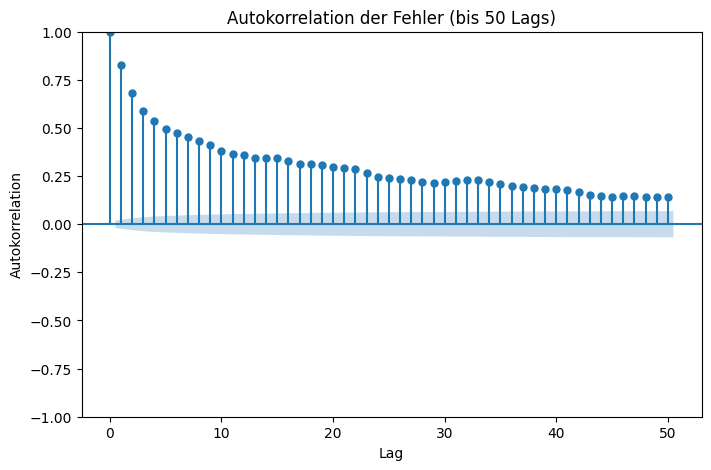

In [22]:
plot_acf_errors(y_test_seq, y_pred)

## Quantile Regression und Prediction Interval: